In [87]:
# research paper: https://dl.acm.org/doi/abs/10.1145/3495002
# dataset: https://www.kaggle.com/datasets/lumaatabbaa/vr-eyes-emotions-dataset-vreed

# objective: to increase model robustness using only eye-tracking data and non-NN machine learning methods

# idea: regression/classification of a feature, then average or replace original feature column with predicted values. For each iteration, 
# do this for every feature. See if the values converge or not. Use the modified values to do actual prediction task. 

# Emotion Prediction through Eye Tracking Data

Eye tracking data from virtual reality or mixed reality headsets can provide plethora of information that can potentially deduce the emotion of the user, which could be used to enhance immersion within a VR/MR application given that it follows strict ethical guidelines. Within the domain of machine learning, this implies that eye tracking data can be used as a part of a classification task. In fact, the dataset used within this project comes from a study (Tabbaa et. al. https://dl.acm.org/doi/abs/10.1145/3495002) done with various 360 virtual environment videos to detect emotional response while simultaneously measuring eye tracking data, ECG (Electrocardiogram) and GSR (Galvanic Skin Reponse). The dataset is published on Kaggle by the same research group (https://www.kaggle.com/datasets/lumaatabbaa/vr-eyes-emotions-dataset-vreed). It is divided into three csv files for eye tracking, ECG and GSR, and each includes rows of experiments along with the corresponding emotional response as derived from the Circumplex Model of Affects. The paper shows preliminary machine learning analysis using Support Vector Machines in prediction of emotional responses given eye tracking only, ECG only, GSR only, or aggregated dataset containing all features. The purpose of this project is to expand upon this prelimnary analysis to include various other classification models, such as logistic regression and ensemble methods, to see if it is possible to improve the reported accuracies.



In [108]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [109]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

## Iterative Data Cleaning and EDA



### Check experiment ordering

The data from the experiments were divided into three separate csv files for Eye Tracking, ECG and GSR. Thus, we need to make sure that the rows in each file correspond with each other. The feature 'Quad_Cat' refers to the derived emotional response from questionnaires at the end of each experiment. Each dataset contains the same feature, but we will do a quick check to see if they are indeed in the same order. 


In [ ]:
# Import datasets
df_ET = pd.read_csv('./data/EyeTracking.csv')
df_ECG = pd.read_csv('./data/ECG.csv')
df_GSR = pd.read_csv('./data/GSR.csv')
labels = df_ET['Quad_Cat']

# The datasets are aligned such that corresponding rows in each dataset refer to the same experimental instance
df_labels = pd.concat([df_ET['Quad_Cat'], df_ECG['Quad_Cat'], df_GSR['Quad_Cat']], axis = 1)

In [90]:
# check that labels in each dataset do indeed correspond with each other
df_labels.corr()

,Quad_Cat,Quad_Cat,Quad_Cat
Quad_Cat,1.0,1.0,1.0
Quad_Cat,1.0,1.0,1.0
Quad_Cat,1.0,1.0,1.0


In [100]:
df_ET.columns

Index(['Quad_Cat', 'Num_of_Fixations', 'Mean_Fixation_Duration',
       'SD_Fixation_Duration', 'Skew_Fixation_Duration',
       'Max_Fixation_Duration', 'First_Fixation_Duration', 'Num_of_Saccade',
       'Mean_Saccade_Duration', 'SD_Saccade_Duration', 'Skew_Saccade_Duration',
       'Max_Saccade_Duration', 'Mean_Saccade_Amplitude',
       'SD_Saccade_Amplitude', 'Skew_Saccade_Amplitude',
       'Max_Saccade_Amplitude', 'Mean_Saccade_Direction',
       'SD_Saccade_Direction', 'Skew_Saccade_Direction',
       'Max_Saccade_Direction', 'Mean_Saccade_Length', 'SD_Saccade_Length',
       'Skew_Saccade_Length', 'Max_Saccade_Length', 'Num_of_Blink',
       'Mean_Blink_Duration', 'SD_Blink_Duration', 'Skew_Blink_Duration',
       'Max_Blink_Duration', 'Num_of_Microsac', 'Mean_Microsac_Peak_Vel',
       'SD_Microsac_Peak_Vel', 'Skew_Microsac_Peak_Vel',
       'Max_Microsac_Peak_Vel', 'Mean_Microsac_Ampl', 'SD_Microsac_Ampl',
       'Skew_Microsac_Ampl', 'Max_Microsac_Ampl', 'Mean_Microsac_Dir'

<Axes: >

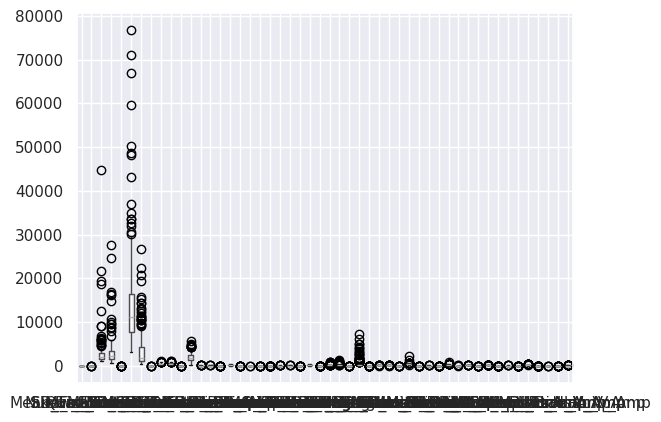

In [99]:
df_ET[df_ET.columns].boxplot()

<Axes: >

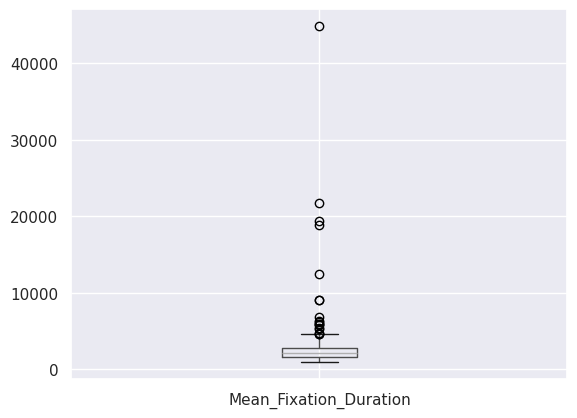

In [101]:
df_ET[['Mean_Fixation_Duration']].boxplot()

In [107]:
Q1 = df_ET['Mean_Fixation_Duration'].quantile(0.25)
Q3 = df_ET['Mean_Fixation_Duration'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_ET[(df_ET['Mean_Fixation_Duration'] < lower_bound) | (df_ET['Mean_Fixation_Duration'] > upper_bound)]
outliers

,Quad_Cat,Num_of_Fixations,Mean_Fixation_Duration,SD_Fixation_Duration,Skew_Fixation_Duration,Max_Fixation_Duration,First_Fixation_Duration,Num_of_Saccade,Mean_Saccade_Duration,SD_Saccade_Duration,...,Skew_Microsac_Dir,Max_Microsac_Dir,Mean_Microsac_H_Amp,SD_Microsac_H_Amp,Skew_Microsac_H_Amp,Max_Microsac_H_Amp,Mean_Microsac_V_Amp,SD_Microsac_V_Amp,Skew_Microsac_V_Amp,Max_Microsac_V_Amp
52,1,0.022222,44860.250000,27628.578390,-0.122971,76825,9774,0.016667,214.666667,224.609290,...,0.005445,179.384870,0.318165,9.567190,2.495247,50.968631,0.372922,2.040257,2.620585,8.804223
53,2,0.052326,18780.555560,16824.371650,0.623588,50243,26781,0.046512,376.750000,375.782517,...,0.283583,179.074328,-2.214138,18.686274,0.903303,58.515132,0.546596,7.035427,3.273806,35.186786
54,2,0.045977,21676.500000,16263.078320,0.025863,43094,11445,0.040230,99.000000,72.711760,...,0.168704,179.589941,1.014925,6.769902,0.179277,18.381401,-0.021408,1.814091,-0.405308,6.089341
55,2,0.051724,19383.000000,24668.233410,1.047052,66889,8012,0.043103,63.600000,28.147824,...,0.022184,178.884463,1.795290,7.863677,0.744910,32.231955,0.045213,2.929176,1.392019,13.628654
56,0,0.079470,12416.666670,14711.995770,1.339510,48198,1511,0.072848,198.636364,157.334213,...,-0.300102,179.114656,1.423353,8.191393,0.454092,29.058429,1.423999,4.173095,2.865332,20.198538
57,1,0.204969,4592.090909,4567.372544,1.987966,22337,8579,0.198758,323.875000,315.901960,...,-0.009501,179.743193,-0.986850,25.581857,1.899872,143.842648,0.599987,4.629217,2.396664,22.551352
59,3,0.106667,9080.125000,5891.942426,-0.086725,16512,15190,0.093333,388.000000,433.975806,...,-0.379646,179.296144,-3.850279,8.756789,-0.721703,10.149288,2.484247,7.780917,2.670543,30.370499
70,3,0.137500,6801.545455,9439.288420,1.601494,31872,11445,0.125000,532.800000,293.168817,...,0.161146,179.407479,-0.931264,22.047066,1.063781,84.697439,-0.169885,4.805522,0.496775,20.203617
75,3,0.165289,5800.350000,8932.394270,2.246337,36914,1805,0.157025,269.842105,292.473600,...,-0.083999,179.906081,1.737555,14.455060,1.874533,59.364479,0.537899,6.649766,2.523345,38.193825
111,3,0.157025,6104.947368,16404.093650,3.284097,71116,1666,0.157025,273.684211,531.042063,...,-0.028215,179.647350,-4.218268,23.025636,-5.568769,14.908442,-1.532577,12.881655,-6.748401,6.950295


In [72]:
# drop labels in each data set
df_ET = df_ET.drop(columns=['Quad_Cat'])
df_ECG = df_ECG.drop(columns=['Quad_Cat'])
df_GSR = df_GSR.drop(columns=['Quad_Cat'])

# add prefix to feature names so that they are distinguishable when combining them into aggregate dataset
df_ET = df_ET.add_prefix('ET_')
df_ECG = df_ECG.add_prefix('ECG_')
df_GSR = df_GSR.add_prefix('GSR_')

In [73]:
df_COMBINED = pd.concat([df_ET, df_ECG, df_GSR], axis = 1)

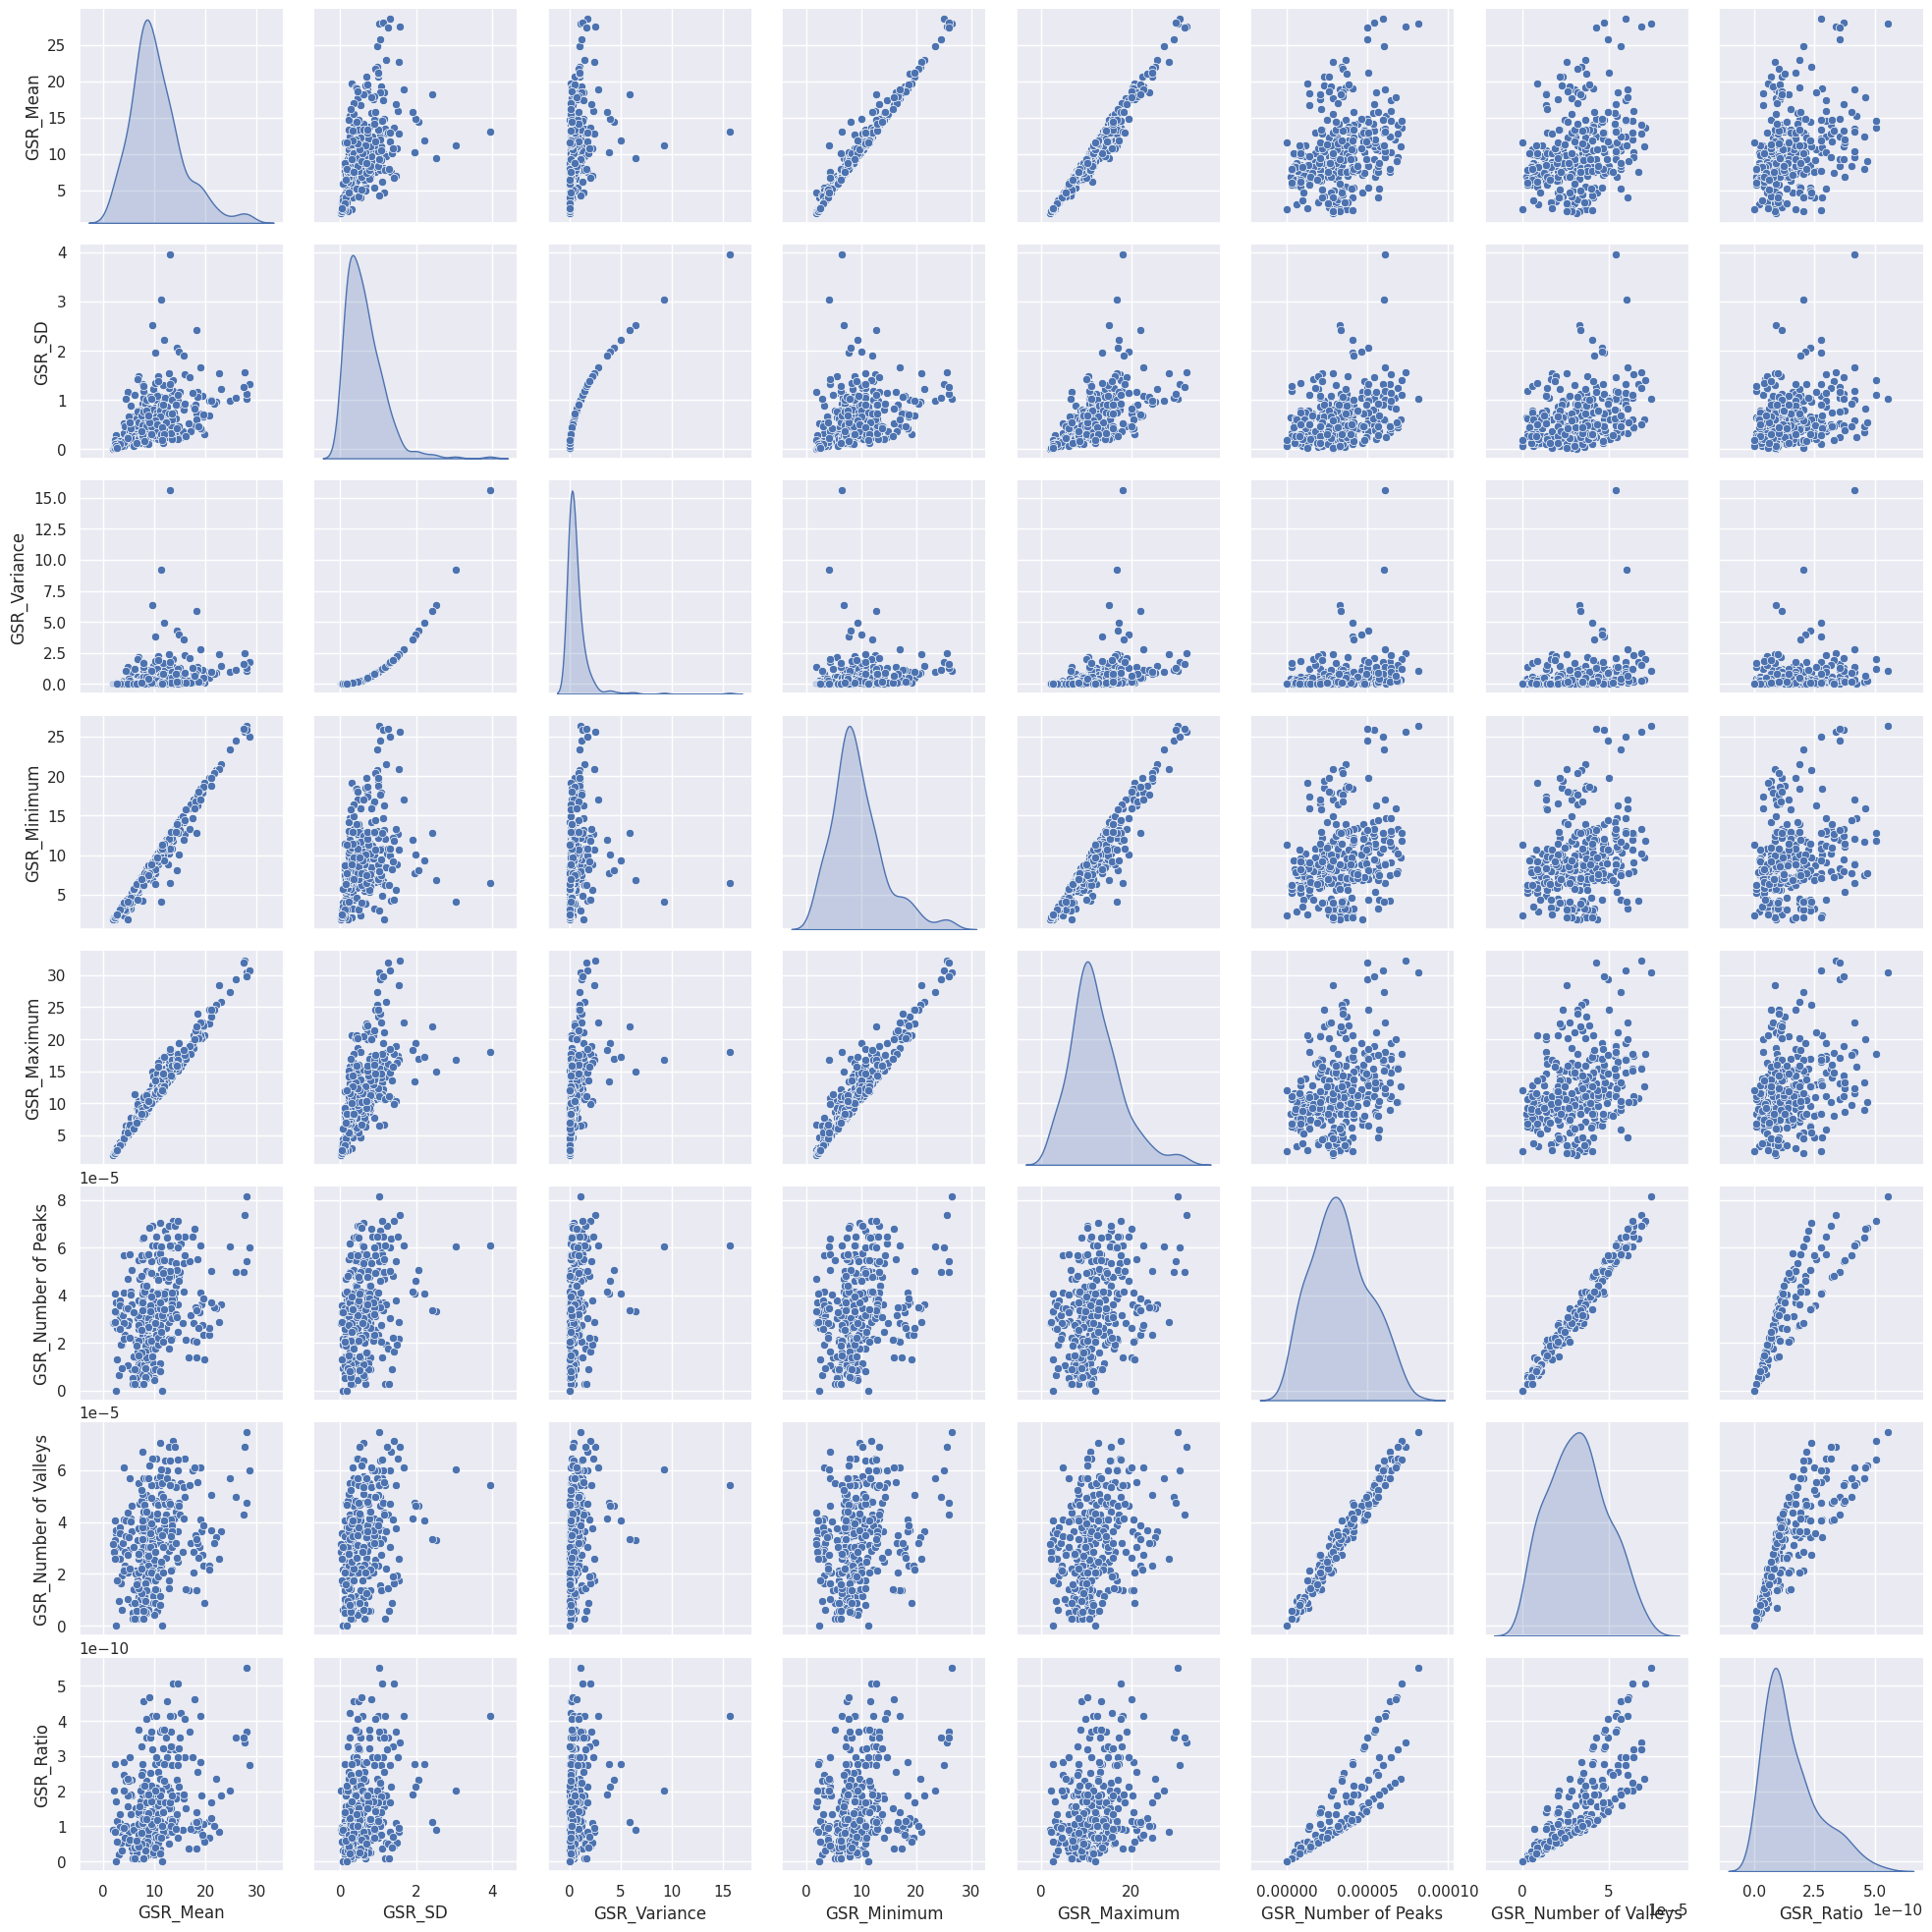

In [76]:
g = sns.pairplot(df_GSR, diag_kind="kde")

In [74]:
df_COMBINED.isna().sum().sum()

np.int64(96)

In [ ]:
from sklearn.preprocessing import StandardScaler

# fill nan's with mean values
df_ET = df_ET.fillna(df_ET.mean())
df_ECG = df_ECG.fillna(df_ECG.mean())
df_GSR = df_GSR.fillna(df_GSR.mean())
df_COMBINED = df_COMBINED.fillna(df_COMBINED.mean())

In [65]:
df_COMBINED.head()

,ET_Num_of_Fixations,ET_Mean_Fixation_Duration,ET_SD_Fixation_Duration,ET_Skew_Fixation_Duration,ET_Max_Fixation_Duration,ET_First_Fixation_Duration,ET_Num_of_Saccade,ET_Mean_Saccade_Duration,ET_SD_Saccade_Duration,ET_Skew_Saccade_Duration,...,ECG_pnn20,ECG_Pnn50pnn20,GSR_Mean,GSR_SD,GSR_Variance,GSR_Minimum,GSR_Maximum,GSR_Number of Peaks,GSR_Number of Valleys,GSR_Ratio
0,1.621535,-0.454633,-0.679505,-0.155565,-0.779439,-0.442632,1.658537,0.458853,0.628405,0.164549,...,0.171762,0.898107,-1.370422,-0.992554,-0.489271,-1.294260,-1.429851,-0.799596,-0.775370,-0.888829
1,0.424474,-0.271174,-0.376489,0.132527,-0.406528,-0.730612,0.385983,0.171314,0.114999,-1.122387,...,0.104844,0.950112,-0.969713,0.047432,-0.168829,-1.140809,-0.874666,0.176780,0.232863,0.300975
2,0.594714,-0.326916,-0.371202,-0.641641,-0.631543,-0.700060,0.529733,0.728825,0.693398,-0.219489,...,-0.204400,0.950112,-1.268068,-0.210397,-0.287093,-1.489450,-1.302003,0.452463,0.517541,1.129431
3,0.386542,-0.251685,-0.086130,1.163586,0.111722,-0.399063,0.364050,-0.095594,0.118233,0.313133,...,-0.576708,0.588066,-1.001626,0.512500,0.109214,-1.316195,-0.777628,0.475437,0.541264,0.327415
4,0.985451,-0.338016,-0.502166,-0.392220,-0.636350,-0.528973,0.981254,-0.330977,-0.288409,0.417352,...,0.277461,0.792718,-1.435824,-0.952979,-0.484699,-1.366812,-1.495501,-0.167823,-0.122984,-0.620021


In [ ]:
# standard scale each feature
df_ET = pd.DataFrame(StandardScaler().fit_transform(df_ET), columns=df_ET.columns)
df_ECG = pd.DataFrame(StandardScaler().fit_transform(df_ECG), columns=df_ECG.columns)
df_GSR = pd.DataFrame(StandardScaler().fit_transform(df_GSR), columns=df_GSR.columns)
df_COMBINED = pd.DataFrame(StandardScaler().fit_transform(df_COMBINED), columns=df_COMBINED.columns)

df_COMBINED_COPY = pd.DataFrame.copy(df_COMBINED)

In [64]:
labels

0      1
1      0
2      0
3      3
4      1
      ..
307    2
308    0
309    1
310    3
311    3
Name: Quad_Cat, Length: 312, dtype: int64

In [62]:
df_COMBINED.corr()

,ET_Num_of_Fixations,ET_Mean_Fixation_Duration,ET_SD_Fixation_Duration,ET_Skew_Fixation_Duration,ET_Max_Fixation_Duration,ET_First_Fixation_Duration,ET_Num_of_Saccade,ET_Mean_Saccade_Duration,ET_SD_Saccade_Duration,ET_Skew_Saccade_Duration,...,ECG_pnn20,ECG_Pnn50pnn20,GSR_Mean,GSR_SD,GSR_Variance,GSR_Minimum,GSR_Maximum,GSR_Number of Peaks,GSR_Number of Valleys,GSR_Ratio
ET_Num_of_Fixations,1.000000,-0.604457,-0.734658,0.172732,-0.718275,-0.410209,0.999119,0.310356,0.343761,0.190974,...,0.001587,0.057426,-0.031133,-0.082772,-0.046696,-0.013711,-0.047219,-0.074388,-0.073778,-0.062173
ET_Mean_Fixation_Duration,-0.604457,1.000000,0.886562,-0.279585,0.706204,0.358865,-0.602993,-0.230428,-0.255638,-0.208530,...,0.044787,0.030092,-0.061387,0.057892,0.019307,-0.069916,-0.040893,-0.053944,-0.051923,-0.038809
ET_SD_Fixation_Duration,-0.734658,0.886562,1.000000,-0.080770,0.918578,0.339606,-0.732574,-0.248090,-0.251009,-0.182559,...,0.029556,0.021072,-0.045730,0.066747,0.025560,-0.059350,-0.025205,-0.011441,-0.012723,-0.012616
ET_Skew_Fixation_Duration,0.172732,-0.279585,-0.080770,1.000000,0.244157,-0.181054,0.175485,0.173949,0.233899,0.148649,...,-0.084109,0.022980,0.080460,-0.008288,-0.012130,0.071840,0.063246,0.015385,0.012661,-0.082032
ET_Max_Fixation_Duration,-0.718275,0.706204,0.918578,0.244157,1.000000,0.283682,-0.714371,-0.228214,-0.198350,-0.101977,...,-0.005872,0.012087,-0.017325,0.062715,0.022004,-0.032797,-0.000485,-0.006487,-0.005771,-0.056692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSR_Minimum,-0.013711,-0.069916,-0.059350,0.071840,-0.032797,-0.025304,-0.016354,0.111894,0.068558,-0.001583,...,0.132205,-0.006347,0.982255,0.285223,0.109878,1.000000,0.943303,0.309728,0.281482,0.284999
GSR_Maximum,-0.047219,-0.040893,-0.025205,0.063246,-0.000485,0.020391,-0.048629,0.036852,-0.002272,0.022946,...,0.140694,0.023735,0.980993,0.573800,0.370272,0.943303,1.000000,0.378274,0.349991,0.329451
GSR_Number of Peaks,-0.074388,-0.053944,-0.011441,0.015385,-0.006487,0.089969,-0.081121,0.137264,0.103710,-0.064282,...,-0.043895,0.014925,0.368421,0.339429,0.250338,0.309728,0.378274,1.000000,0.985503,0.848455
GSR_Number of Valleys,-0.073778,-0.051923,-0.012723,0.012661,-0.005771,0.087127,-0.080180,0.128050,0.101421,-0.049485,...,-0.043487,0.018899,0.340599,0.328542,0.240705,0.281482,0.349991,0.985503,1.000000,0.815625


<Axes: >

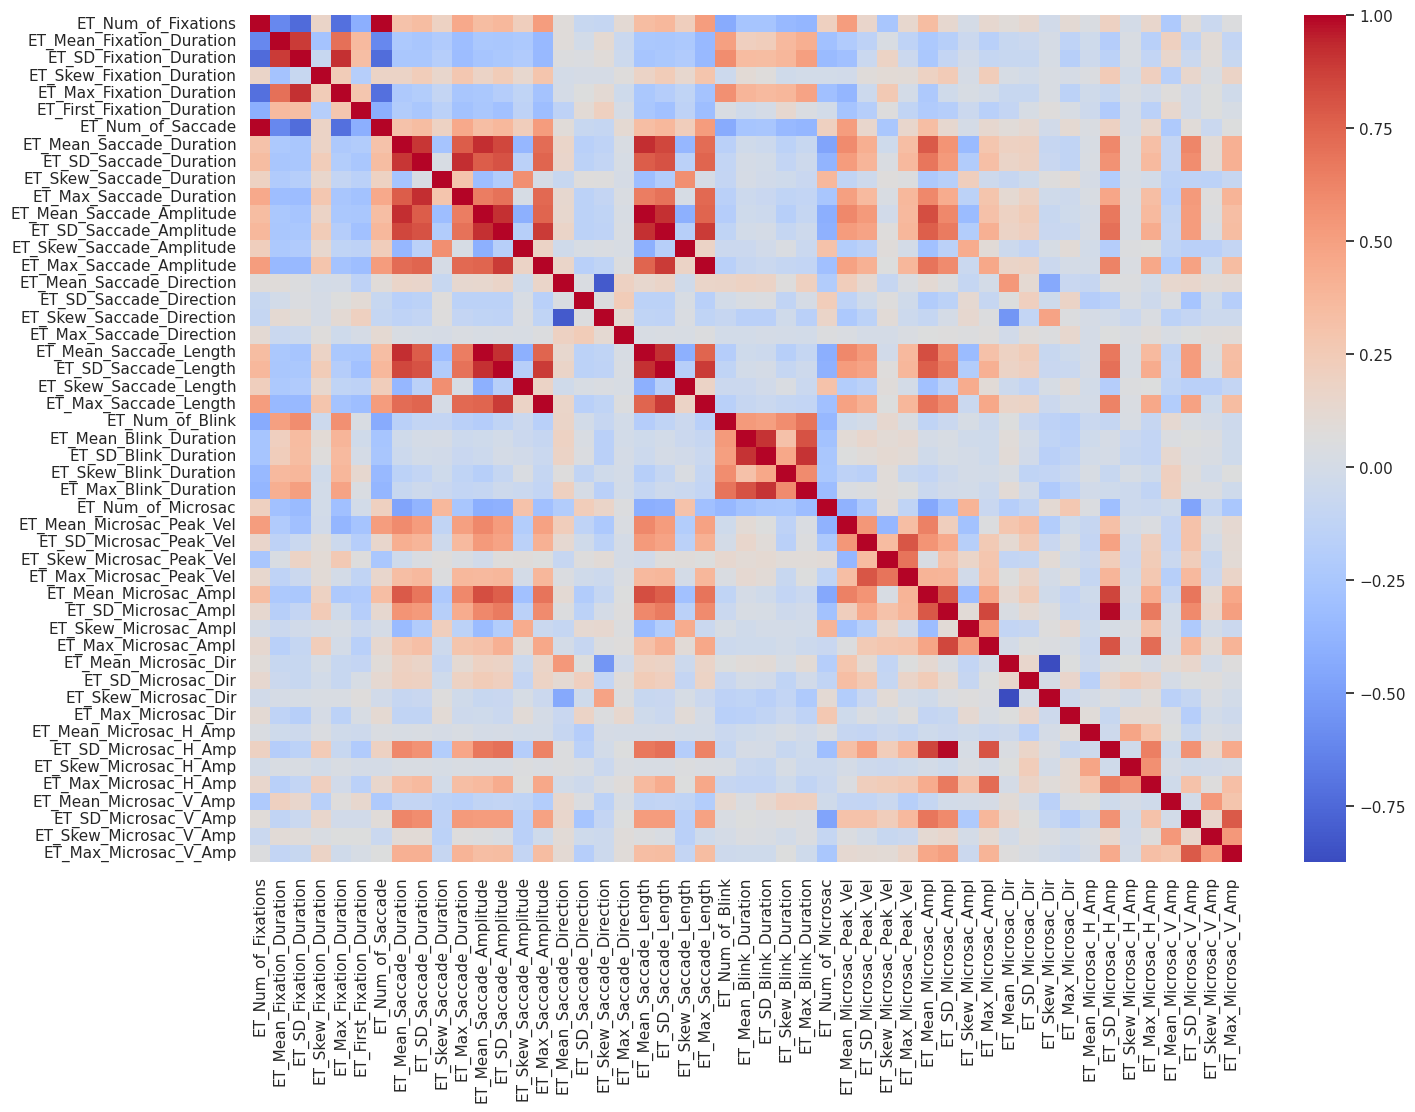

In [47]:
plt.figure(figsize=(16, 11))
sns.set(
    rc = {
        'font.size':9
    }
)
sns.heatmap(df_COMBINED.corr(), annot=False, cmap="coolwarm")

In [131]:
corr = df_COMBINED.corr().abs()

visited = set()

columns = corr.columns
# print(columns)
for i in range(len(columns)):
    for j in range(i+1,len(columns)):
        if corr.iloc[i][j] > 0.90 and corr.iloc[i][j] < .99:
            # print(columns[i], columns[j], corr.iloc[i][j])
            if columns[i] not in visited and columns[j] not in visited:
                visited.add(columns[i])
                print(corr.iloc[i][j])
print(len(columns), len(visited))
print(list(visited))

df_COMBINED.drop(list(visited), axis=1, inplace=True)

# TODO: find collinearities

0.9185782023083294
0.903044322858022
0.9206841501303374
0.9167471972640386
0.9167471972647756
0.9167471972607715
0.9104559325951811
0.9054927129472031
0.9868107875527542
0.9837868123219821
0.9822552465935727
0.9433033108776329
0.9855029975746447
75 13
['ET_SD_Saccade_Amplitude', 'ECG_Ibi', 'GSR_Number of Peaks', 'ET_Mean_Saccade_Length', 'ET_Mean_Saccade_Amplitude', 'GSR_Minimum', 'ET_SD_Blink_Duration', 'ET_SD_Microsac_Ampl', 'GSR_Mean', 'ET_SD_Fixation_Duration', 'ET_SD_Saccade_Duration', 'ET_Mean_Saccade_Duration', 'ET_Mean_Blink_Duration']


<Axes: >

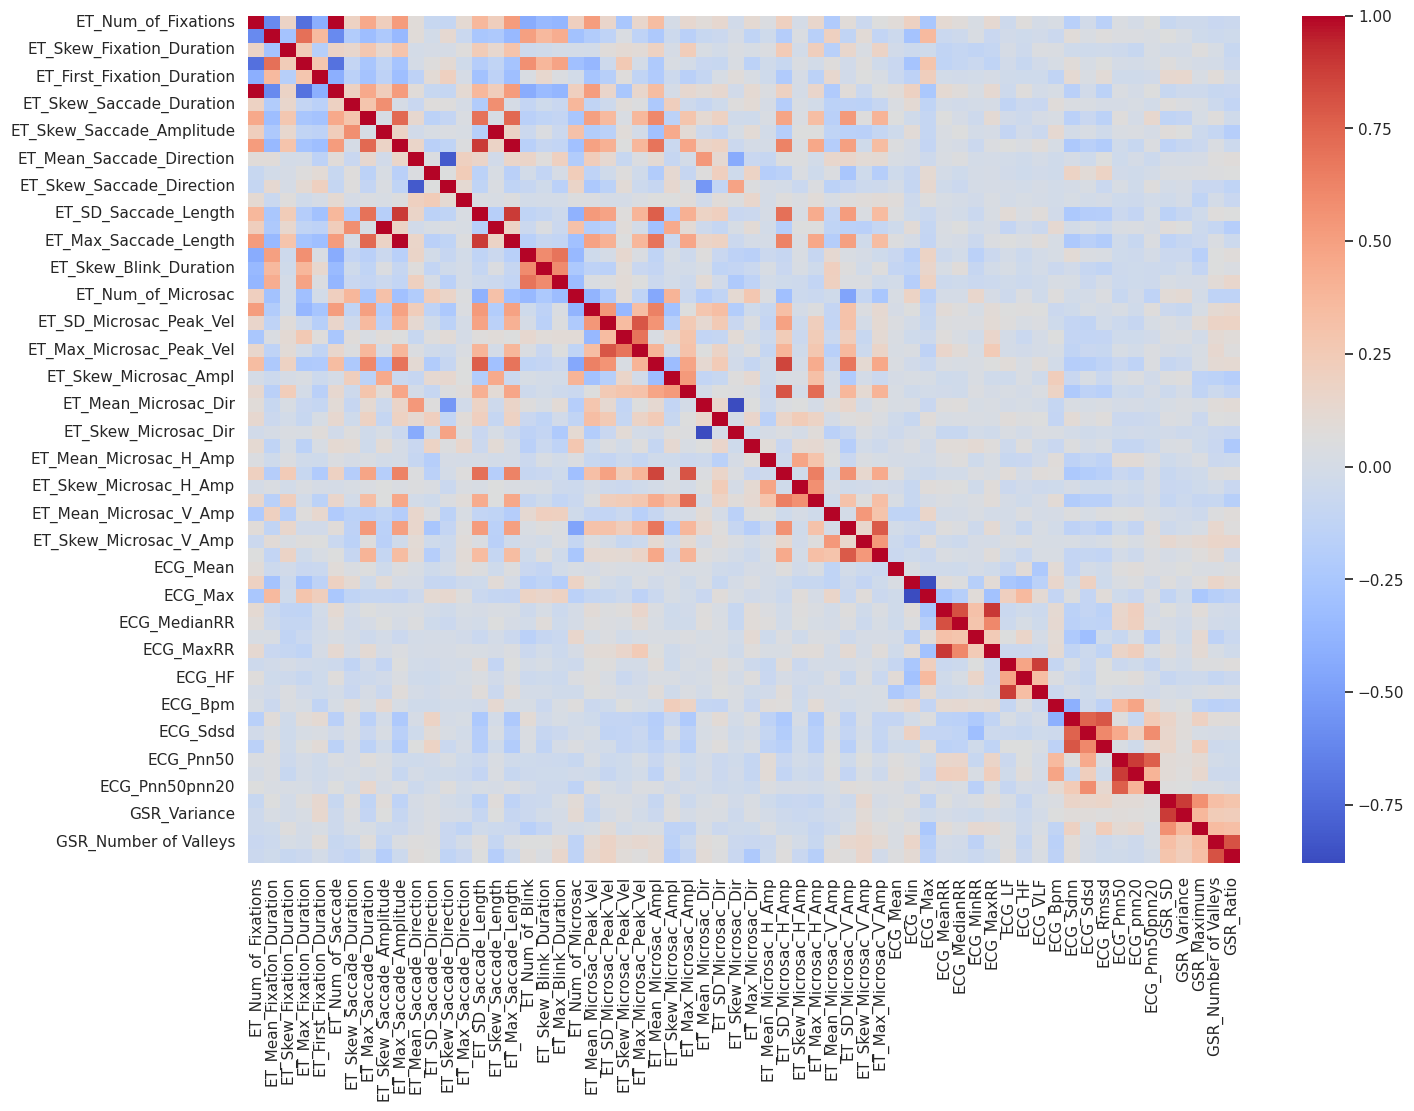

In [132]:
plt.figure(figsize=(16, 11))
sns.set(
    rc = {
        'font.size':9
    }
)
sns.heatmap(df_COMBINED.corr(), annot=False, cmap="coolwarm")

In [18]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train_COMBINED, X_test_COMBINED, y_train_COMBINED, y_test_COMBINED =  train_test_split(df_COMBINED, labels, test_size=0.1)

logreg = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
    'l1_ratio': [0.1, 0.5, 0.9],
}

grid_logistic_COMBINED = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=0)

grid_logistic_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_logistic_COMBINED.best_params_
best_score = grid_logistic_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_logistic_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'C': 1, 'class_weight': None, 'l1_ratio': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.7214285714285713
[2 1 2 3 1 2 2 1 2 2 0 2 3 0 0 3 3 0 0 1 2 0 3 0 1 2 3 1 0 3 1 3]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.6875


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [0, 5, 10, 20, 30, 40, 50],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

grid_knn_COMBINED = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)
grid_knn_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_knn_COMBINED.best_params_
best_score = grid_knn_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_knn_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
0.48571428571428565
[2 2 1 0 2 2 2 1 2 0 1 0 2 0 2 3 1 2 0 1 2 0 0 2 1 2 1 1 0 2 2 1]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.4375


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()
grid_rf_COMBINED = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)
grid_rf_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_rf_COMBINED.best_params_
best_score = grid_rf_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_rf_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.7107142857142857
[2 1 1 3 1 2 2 1 2 0 0 0 0 0 0 3 3 0 0 1 2 0 3 0 1 2 3 1 0 3 0 3]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.65625


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

parameters = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': np.logspace(-10, 10, 11, base=2)
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1))

grid_ada_COMBINED = GridSearchCV(ada, parameters, cv=10, scoring='accuracy', verbose=0)

grid_ada_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_ada_COMBINED.best_params_
best_score = grid_ada_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_ada_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'learning_rate': np.float64(0.00390625), 'n_estimators': 300}
0.5785714285714285
[1 1 2 3 1 1 1 1 2 1 0 1 0 0 1 0 0 1 3 1 2 0 0 3 1 2 0 1 3 3 0 3]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.625


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {'kernel':['linear', 'rbf'], 
              'C':np.logspace(-5, 5, 11, base=2),
              'gamma':np.logspace(-5, 5, 11, base=2)
             }
svc = SVC()
grid_svc_COMBINED = GridSearchCV(svc, parameters, cv=10, scoring='accuracy')

grid_svc_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_svc_COMBINED.best_params_
best_score = grid_svc_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_svc_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'C': np.float64(2.0), 'gamma': np.float64(0.03125), 'kernel': 'linear'}
0.6857142857142857
[2 1 2 3 1 2 2 1 2 2 0 2 0 0 0 3 3 1 0 1 2 0 3 0 1 2 3 1 0 2 1 0]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.6875


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 60, 70, 80, 90, 100, 110],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

dt = DecisionTreeClassifier()

grid_dt_COMBINED = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)

grid_dt_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_dt_COMBINED.best_params_
best_score = grid_dt_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_dt_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'criterion': 'entropy', 'max_depth': 60, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 2, 'splitter': 'random'}
0.6
[0 1 1 0 1 0 0 1 2 1 0 0 0 0 1 3 3 1 3 1 2 3 3 0 1 2 3 1 0 2 1 3]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.59375


In [24]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

f_ET = [] 
f_ECG_GSR = []

for i in range(len(df_COMBINED.columns)):
    feature = df_COMBINED.columns[i]
    if feature[:3] == 'ET_':
        f_ET.append(feature)
    else:
        f_ECG_GSR.append(feature)
        
X_train_ET = X_train_COMBINED[f_ET]
X_test_ET = X_test_COMBINED[f_ET]
y_train_ET = y_train_COMBINED
y_test_ET = y_test_COMBINED

logreg = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
    'l1_ratio': [0.1, 0.5, 0.9],
}

grid_logistic = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=1)

grid_logistic.fit(X_train_ET, y_train_ET)

best_params = grid_logistic.best_params_
best_score = grid_logistic.best_score_

print(best_params)
print(best_score)

prediction = grid_logistic.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits
{'C': 1, 'class_weight': None, 'l1_ratio': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.6357142857142858
[2 3 2 3 1 2 2 1 2 2 3 2 0 0 0 3 3 0 0 2 2 3 3 0 1 2 3 1 0 2 2 1]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.625


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [0, 5, 10, 20, 30, 40, 50],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)
grid_knn.fit(X_train_ET, y_train_ET)

best_params = grid_knn.best_params_
best_score = grid_knn.best_score_

print(best_params)
print(best_score)

prediction = grid_knn.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
0.4892857142857142
[2 0 1 0 1 1 2 1 2 0 3 3 0 0 2 1 3 1 0 1 2 0 1 0 1 2 1 1 0 2 1 1]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.5


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [None, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
grid_rf.fit(X_train_ET, y_train_ET)

best_params = grid_rf.best_params_
best_score = grid_rf.best_score_

print(best_params)
print(best_score)

prediction = grid_rf.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
0.5892857142857143
[2 1 1 3 1 2 2 1 2 0 3 0 3 3 0 3 3 0 0 2 2 3 3 0 1 2 1 1 0 2 1 1]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.5


In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

parameters = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': np.logspace(-10, 10, 11, base=2)
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1))

grid_ada = GridSearchCV(ada, parameters, cv=10, scoring='accuracy', verbose=0)

grid_ada.fit(X_train_ET, y_train_ET)

best_params = grid_ada.best_params_
best_score = grid_ada.best_score_

print(best_params)
print(best_score)

prediction = grid_ada.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'learning_rate': np.float64(0.015625), 'n_estimators': 300}
0.5214285714285715
[1 1 2 0 1 1 1 1 2 3 3 3 0 0 0 3 1 0 0 1 2 0 3 0 1 2 1 1 0 3 1 1]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.5625


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {'kernel':['linear', 'rbf'], 
              'C':np.logspace(-5, 5, 11, base=2),
              'gamma':np.logspace(-5, 5, 11, base=2)
             }
svc = SVC()
grid_svc = GridSearchCV(svc, parameters, cv=10, scoring='accuracy')

grid_svc.fit(X_train_ET, y_train_ET)

best_params = grid_svc.best_params_
best_score = grid_svc.best_score_

print(best_params)
print(best_score)

prediction = grid_svc.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'C': np.float64(0.0625), 'gamma': np.float64(0.03125), 'kernel': 'linear'}
0.6107142857142857
[2 3 3 3 1 2 2 1 2 2 3 2 0 0 0 3 3 0 0 1 2 3 3 0 1 2 3 1 0 2 1 1]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.53125


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 60, 70, 80, 90, 100, 110],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

dt = DecisionTreeClassifier()

grid_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)

grid_dt.fit(X_train_ET, y_train_ET)

best_params = grid_dt.best_params_
best_score = grid_dt.best_score_

print(best_params)
print(best_score)

prediction = grid_dt.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'criterion': 'entropy', 'max_depth': 110, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 20, 'splitter': 'best'}
0.48571428571428577
[0 3 1 3 1 2 3 0 2 0 3 0 0 0 0 1 3 0 3 3 0 0 3 2 0 2 1 3 0 2 0 3]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.3125


In [75]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning

mlp = MLPClassifier(max_iter=1000, random_state=42, verbose=False)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],  
    'alpha': [0.0001, 0.001, 0.01],  
    'learning_rate': ['constant', 'adaptive'],  
    'learning_rate_init': [0.001, 0.01, 0.1],  
    'batch_size': ['auto', 64, 128], 
}

grid_mlp_COMBINED = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=0)

grid_mlp_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_mlp_COMBINED.best_params_
best_score = grid_mlp_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_mlp_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

KeyboardInterrupt: 

In [ ]:
# TODO: accuracy, precision, recall, AUC curve